## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras
from keras.datasets import cifar10

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.np_utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
# 建立神經網路
from keras.regularizers import l1, l2, l1_l2
def build_mlp(input_shape, regularization, ratio, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    if regularization =='l1':
        for i, n_units in enumerate(num_neurons):
            if i == 0:
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1), 
                                       kernel_regularizer=l1(ratio))(input_layer)
            else:
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1),
                                       kernel_regularizer=l1(ratio))(x)

    elif regularization =='l2':
        for i, n_units in enumerate(num_neurons):
            if i == 0:
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1), 
                                       kernel_regularizer=l2(ratio))(input_layer)
            else:
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1),
                                       kernel_regularizer=l2(ratio))(x)
    else:
        for i, n_units in enumerate(num_neurons):
            if i == 0:
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1), 
                                       kernel_regularizer=l1_l2(ratio))(input_layer)
            else:
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1),
                                       kernel_regularizer=l1_l2(ratio))(x)
        
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
#設定超參數
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
EXP = [1e-2, 1e-4, 1e-8, 1e-12]
REGULARIZATION = ['l1', 'l2', 'l1_l2']

In [7]:
results = {}
# 撰寫訓練流程並將結果用 dictionary 紀錄
for regularization in REGULARIZATION:
    for regularier_ratio in EXP:
        keras.backend.clear_session() # 把舊的 Graph 清掉
        print(f"Regularization: {regularization}, Ratio: {regularier_ratio}")
        model = build_mlp(input_shape=x_train.shape[1:], 
                          regularization=regularization, 
                          ratio=regularier_ratio,
                          output_units=10, num_neurons=[512, 256, 128])
        model.summary()
        
        optimizer = keras.optimizers.gradient_descent_v2.SGD(learning_rate=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
        
        model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
        
        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["accuracy"]
        valid_acc = model.history.history["val_accuracy"]

        exp_name_tag = "Regularization: %s, Ratio: %s" %(regularization, str(regularier_ratio))
        results[exp_name_tag] = {'train-loss': train_loss,
                                 'valid-loss': valid_loss,
                                 'train-acc': train_acc,
                                 'valid-acc': valid_acc}       

Regularization: l1, Ratio: 0.01
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3072)]            0         
                                                                 
 hidden_layer1 (Dense)       (None, 512)               1573376   
                                                                 
 hidden_layer2 (Dense)       (None, 256)               131328    
                                                                 
 hidden_layer3 (Dense)       (None, 128)               32896     
                                                                 
 output (Dense)              (None, 10)                1290      
                                                                 
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
196/196 

196/196 [==============================] - 4s 21ms/step - loss: 2.4626 - accuracy: 0.0973 - val_loss: 2.4624 - val_accuracy: 0.1000
Regularization: l1, Ratio: 0.0001
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3072)]            0         
                                                                 
 hidden_layer1 (Dense)       (None, 512)               1573376   
                                                                 
 hidden_layer2 (Dense)       (None, 256)               131328    
                                                                 
 hidden_layer3 (Dense)       (None, 128)               32896     
                                                                 
 output (Dense)              (None, 10)                1290      
                                                                 
Total params: 1,738,890
Tra

196/196 [==============================] - 4s 21ms/step - loss: 2.6781 - accuracy: 0.6231 - val_loss: 3.0104 - val_accuracy: 0.5040
Epoch 50/50
196/196 [==============================] - 4s 21ms/step - loss: 2.6374 - accuracy: 0.6255 - val_loss: 2.8542 - val_accuracy: 0.5426
Regularization: l1, Ratio: 1e-08
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3072)]            0         
                                                                 
 hidden_layer1 (Dense)       (None, 512)               1573376   
                                                                 
 hidden_layer2 (Dense)       (None, 256)               131328    
                                                                 
 hidden_layer3 (Dense)       (None, 128)               32896     
                                                                 
 output (Dense) 

196/196 [==============================] - 4s 21ms/step - loss: 0.9137 - accuracy: 0.6781 - val_loss: 1.4419 - val_accuracy: 0.5156
Epoch 49/50
196/196 [==============================] - 4s 21ms/step - loss: 0.9047 - accuracy: 0.6829 - val_loss: 1.4557 - val_accuracy: 0.5176
Epoch 50/50
196/196 [==============================] - 4s 21ms/step - loss: 0.8868 - accuracy: 0.6895 - val_loss: 1.3820 - val_accuracy: 0.5304
Regularization: l1, Ratio: 1e-12
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3072)]            0         
                                                                 
 hidden_layer1 (Dense)       (None, 512)               1573376   
                                                                 
 hidden_layer2 (Dense)       (None, 256)               131328    
                                                                 
 hid

196/196 [==============================] - 4s 19ms/step - loss: 0.8804 - accuracy: 0.6920 - val_loss: 1.3882 - val_accuracy: 0.5287
Epoch 48/50
196/196 [==============================] - 4s 19ms/step - loss: 0.8695 - accuracy: 0.6950 - val_loss: 1.3829 - val_accuracy: 0.5299
Epoch 49/50
196/196 [==============================] - 4s 19ms/step - loss: 0.8573 - accuracy: 0.6975 - val_loss: 1.3786 - val_accuracy: 0.5361
Epoch 50/50
196/196 [==============================] - 4s 19ms/step - loss: 0.8442 - accuracy: 0.7036 - val_loss: 1.4115 - val_accuracy: 0.5286
Regularization: l2, Ratio: 0.01
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3072)]            0         
                                                                 
 hidden_layer1 (Dense)       (None, 512)               1573376   
                                                           

196/196 [==============================] - 4s 22ms/step - loss: 1.6233 - accuracy: 0.5203 - val_loss: 1.7419 - val_accuracy: 0.4708
Epoch 47/50
196/196 [==============================] - 4s 22ms/step - loss: 1.6205 - accuracy: 0.5212 - val_loss: 1.6935 - val_accuracy: 0.4948
Epoch 48/50
196/196 [==============================] - 4s 22ms/step - loss: 1.6172 - accuracy: 0.5234 - val_loss: 1.6793 - val_accuracy: 0.5006
Epoch 49/50
196/196 [==============================] - 4s 22ms/step - loss: 1.6153 - accuracy: 0.5253 - val_loss: 1.6746 - val_accuracy: 0.4993
Epoch 50/50
196/196 [==============================] - 4s 22ms/step - loss: 1.6106 - accuracy: 0.5259 - val_loss: 1.6819 - val_accuracy: 0.4861
Regularization: l2, Ratio: 0.0001
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3072)]            0         
                                             

196/196 [==============================] - 5s 23ms/step - loss: 1.0641 - accuracy: 0.6756 - val_loss: 1.7174 - val_accuracy: 0.4943
Epoch 46/50
196/196 [==============================] - 5s 23ms/step - loss: 1.0564 - accuracy: 0.6782 - val_loss: 1.5758 - val_accuracy: 0.5227
Epoch 47/50
196/196 [==============================] - 5s 27ms/step - loss: 1.0397 - accuracy: 0.6840 - val_loss: 1.5887 - val_accuracy: 0.5106
Epoch 48/50
196/196 [==============================] - 4s 23ms/step - loss: 1.0338 - accuracy: 0.6860 - val_loss: 1.5273 - val_accuracy: 0.5351
Epoch 49/50
196/196 [==============================] - 4s 22ms/step - loss: 1.0152 - accuracy: 0.6913 - val_loss: 1.5142 - val_accuracy: 0.5334
Epoch 50/50
196/196 [==============================] - 4s 22ms/step - loss: 1.0107 - accuracy: 0.6964 - val_loss: 1.5354 - val_accuracy: 0.5253
Regularization: l2, Ratio: 1e-08
Model: "model"
_________________________________________________________________
 Layer (type)                Outpu

196/196 [==============================] - 4s 22ms/step - loss: 0.9450 - accuracy: 0.6669 - val_loss: 1.3640 - val_accuracy: 0.5302
Epoch 45/50
196/196 [==============================] - 4s 22ms/step - loss: 0.9289 - accuracy: 0.6728 - val_loss: 1.3312 - val_accuracy: 0.5372
Epoch 46/50
196/196 [==============================] - 4s 22ms/step - loss: 0.9192 - accuracy: 0.6757 - val_loss: 1.4165 - val_accuracy: 0.5176
Epoch 47/50
196/196 [==============================] - 4s 22ms/step - loss: 0.9046 - accuracy: 0.6813 - val_loss: 1.4150 - val_accuracy: 0.5220
Epoch 48/50
196/196 [==============================] - 4s 22ms/step - loss: 0.8946 - accuracy: 0.6848 - val_loss: 1.4036 - val_accuracy: 0.5245
Epoch 49/50
196/196 [==============================] - 4s 22ms/step - loss: 0.8824 - accuracy: 0.6885 - val_loss: 1.4573 - val_accuracy: 0.5158
Epoch 50/50
196/196 [==============================] - 4s 22ms/step - loss: 0.8734 - accuracy: 0.6946 - val_loss: 1.3837 - val_accuracy: 0.5319
Regu

196/196 [==============================] - 5s 23ms/step - loss: 0.9562 - accuracy: 0.6635 - val_loss: 1.5299 - val_accuracy: 0.4929
Epoch 44/50
196/196 [==============================] - 5s 23ms/step - loss: 0.9411 - accuracy: 0.6669 - val_loss: 1.3419 - val_accuracy: 0.5330
Epoch 45/50
196/196 [==============================] - 5s 23ms/step - loss: 0.9296 - accuracy: 0.6738 - val_loss: 1.3530 - val_accuracy: 0.5383
Epoch 46/50
196/196 [==============================] - 5s 23ms/step - loss: 0.9147 - accuracy: 0.6763 - val_loss: 1.4541 - val_accuracy: 0.5100
Epoch 47/50
196/196 [==============================] - 5s 23ms/step - loss: 0.9064 - accuracy: 0.6801 - val_loss: 1.3560 - val_accuracy: 0.5371
Epoch 48/50
196/196 [==============================] - 5s 23ms/step - loss: 0.8928 - accuracy: 0.6864 - val_loss: 1.3975 - val_accuracy: 0.5296
Epoch 49/50
196/196 [==============================] - 5s 24ms/step - loss: 0.8836 - accuracy: 0.6896 - val_loss: 1.3970 - val_accuracy: 0.5301
Epoc

196/196 [==============================] - 5s 28ms/step - loss: 2.4615 - accuracy: 0.0985 - val_loss: 2.4614 - val_accuracy: 0.1000
Epoch 43/50
196/196 [==============================] - 5s 27ms/step - loss: 2.4615 - accuracy: 0.0983 - val_loss: 2.4614 - val_accuracy: 0.1000
Epoch 44/50
196/196 [==============================] - 5s 27ms/step - loss: 2.4615 - accuracy: 0.0969 - val_loss: 2.4613 - val_accuracy: 0.1000
Epoch 45/50
196/196 [==============================] - 5s 27ms/step - loss: 2.4615 - accuracy: 0.0976 - val_loss: 2.4614 - val_accuracy: 0.1000
Epoch 46/50
196/196 [==============================] - 5s 28ms/step - loss: 2.4615 - accuracy: 0.0987 - val_loss: 2.4614 - val_accuracy: 0.1000
Epoch 47/50
196/196 [==============================] - 5s 28ms/step - loss: 2.4615 - accuracy: 0.0986 - val_loss: 2.4614 - val_accuracy: 0.1000
Epoch 48/50
196/196 [==============================] - 5s 27ms/step - loss: 2.4614 - accuracy: 0.1003 - val_loss: 2.4612 - val_accuracy: 0.1000
Epoc

196/196 [==============================] - 6s 28ms/step - loss: 1.7908 - accuracy: 0.4730 - val_loss: 1.8516 - val_accuracy: 0.4405
Epoch 42/50
196/196 [==============================] - 6s 28ms/step - loss: 1.7837 - accuracy: 0.4727 - val_loss: 1.8338 - val_accuracy: 0.4517
Epoch 43/50
196/196 [==============================] - 6s 28ms/step - loss: 1.7807 - accuracy: 0.4728 - val_loss: 1.7899 - val_accuracy: 0.4761
Epoch 44/50
196/196 [==============================] - 6s 28ms/step - loss: 1.7773 - accuracy: 0.4743 - val_loss: 1.7880 - val_accuracy: 0.4727
Epoch 45/50
196/196 [==============================] - 6s 28ms/step - loss: 1.7701 - accuracy: 0.4759 - val_loss: 1.8007 - val_accuracy: 0.4732
Epoch 46/50
196/196 [==============================] - 6s 29ms/step - loss: 1.7684 - accuracy: 0.4774 - val_loss: 1.7836 - val_accuracy: 0.4755
Epoch 47/50
196/196 [==============================] - 6s 29ms/step - loss: 1.7632 - accuracy: 0.4779 - val_loss: 1.8514 - val_accuracy: 0.4424
Epoc

196/196 [==============================] - 6s 28ms/step - loss: 1.6587 - accuracy: 0.5146 - val_loss: 1.7038 - val_accuracy: 0.4933
Epoch 41/50
196/196 [==============================] - 6s 28ms/step - loss: 1.6488 - accuracy: 0.5162 - val_loss: 1.6935 - val_accuracy: 0.4974
Epoch 42/50
196/196 [==============================] - 6s 28ms/step - loss: 1.6460 - accuracy: 0.5145 - val_loss: 1.6935 - val_accuracy: 0.4959
Epoch 43/50
196/196 [==============================] - 6s 28ms/step - loss: 1.6397 - accuracy: 0.5165 - val_loss: 1.6785 - val_accuracy: 0.4966
Epoch 44/50
196/196 [==============================] - 6s 28ms/step - loss: 1.6339 - accuracy: 0.5188 - val_loss: 1.6872 - val_accuracy: 0.5008
Epoch 45/50
196/196 [==============================] - 6s 28ms/step - loss: 1.6299 - accuracy: 0.5203 - val_loss: 1.6961 - val_accuracy: 0.4974
Epoch 46/50
196/196 [==============================] - 6s 28ms/step - loss: 1.6233 - accuracy: 0.5212 - val_loss: 1.6949 - val_accuracy: 0.4952
Epoc

196/196 [==============================] - 5s 28ms/step - loss: 1.6684 - accuracy: 0.5081 - val_loss: 1.7270 - val_accuracy: 0.4923
Epoch 40/50
196/196 [==============================] - 5s 28ms/step - loss: 1.6599 - accuracy: 0.5076 - val_loss: 1.7428 - val_accuracy: 0.4823
Epoch 41/50
196/196 [==============================] - 5s 28ms/step - loss: 1.6548 - accuracy: 0.5091 - val_loss: 1.7119 - val_accuracy: 0.4886
Epoch 42/50
196/196 [==============================] - 5s 28ms/step - loss: 1.6452 - accuracy: 0.5158 - val_loss: 1.6980 - val_accuracy: 0.4930
Epoch 43/50
196/196 [==============================] - 5s 28ms/step - loss: 1.6417 - accuracy: 0.5121 - val_loss: 1.6941 - val_accuracy: 0.4947
Epoch 44/50
196/196 [==============================] - 6s 29ms/step - loss: 1.6353 - accuracy: 0.5138 - val_loss: 1.6992 - val_accuracy: 0.4825
Epoch 45/50
196/196 [==============================] - 6s 30ms/step - loss: 1.6319 - accuracy: 0.5152 - val_loss: 1.7001 - val_accuracy: 0.4906
Epoc

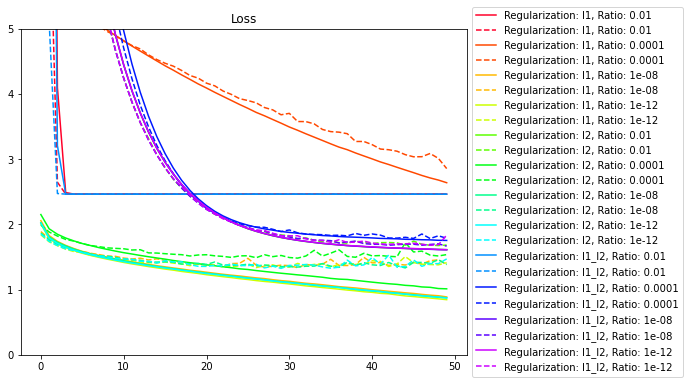

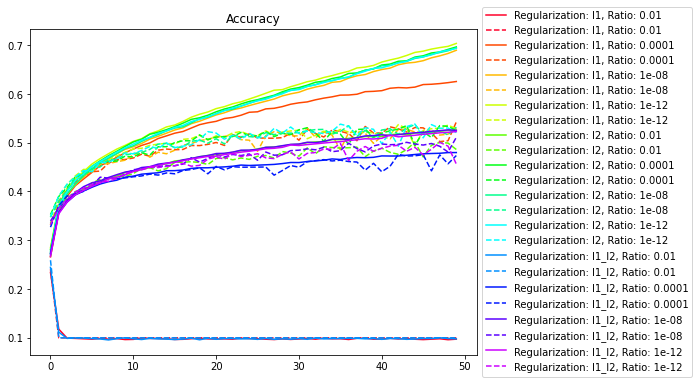

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline

NUM_COLORS = 12
cm = plt.get_cmap('gist_rainbow')
cNorm = colors.Normalize(vmin=0, vmax=NUM_COLORS)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [ scalarMap.to_rgba(i) for i in range(NUM_COLORS)]
"""Code Here
將結果繪出
"""

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()